## Optimum Data Size for Model Training

Give the large size of my dataset which contains more than 11 million observations, and the limited time and computational resources available to me during this priject, I decided to reduce the size of the training data to something more managable.

One way to do this is to implement the <code>learning_curve</code> module from <code>sklearn</code>. Using this library, we can determine the training score and the cross-validated score for different training set sizes. We. can also check model's fitting time which is directly related to its scalability.

Given that this analysis in itself is very time consuming, I've decided to limit the number of tested models to two: <code>DecisionTreeClassifier</code> and <code>KNeighborsClassifier</code>. I've aditionally reduced the size of the training set to just 2% of its original size. Although this seams small, it should still be enough for us to make a decision on apparent patterns, instead of absolute figures.

The code used in this notebook was partially copied from the example provided [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py).

In [1]:
#importing the necessary python libraries
import pandas as pd
import numpy as np
import joblib as jl
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
#loading the csv file containing the complete data
all_features = pd.read_csv('../../../../resource-datasets/capstone-data/agg-data/airport-weather-agg.csv',
                                  infer_datetime_format=True)

#converting the time column into pandas datetime
all_features['time'] = pd.to_datetime(all_features['time'])

#creating a binary variable to act as target variable indicating whether a flight was delayed or not
all_features['dep_15_del'] = all_features['dep_delay'].apply(lambda x: 1 if x>15 else 0)

#extracting month, day, day of week and hour information from each observation's timestamp
#to act as further predictors
all_features['month'] = all_features['time'].dt.month
all_features['day'] = all_features['time'].dt.day
all_features['day_of_week'] = all_features['time'].dt.weekday
all_features['hour'] = all_features['time'].dt.hour

#creating a random sample from the data
sample_obs = all_features.sample(frac=0.02, random_state=1)

#creating the predictor dataframe
X = sample_obs[['origin', 'carrier', 'precipitation', 'condition', 'cloud_base', 'dew_temp', 'pressure',
                   'air_temp', 'visibility', 'wind_speed', 'wind_direction', 'month', 'day', 'day_of_week', 'hour']]

#putting the target variable aside
y = sample_obs['dep_15_del']

#dummifying the categorical variables
X_dum = pd.get_dummies(X, columns=['carrier', 'condition', 'origin', 'wind_direction',
                                        'month', 'day', 'day_of_week', 'hour'], drop_first=True)

#creating intraction features between origin and wind direction data
for origin in X_dum.columns[45:64]:
    for wind_direction in X_dum.columns[64:71]:
        column_name = origin+'_'+wind_direction
        X_dum[column_name] = X_dum[origin] * X_dum[wind_direction]
        
#converting the dataframe to a sparse matrix for better memory management
X_sparse = sparse.csr_matrix(X_dum.values)

#instantiating a StandardScaler to scale the data
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_sparse)

In [2]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

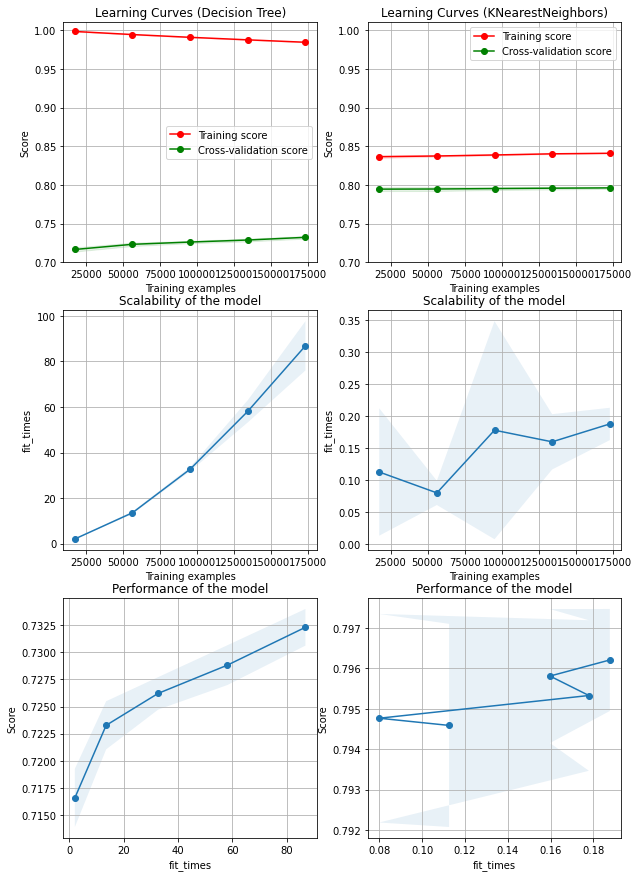

In [4]:
#create a figure to plot the different metrics
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#set up a DecisionTreeClassifier instance with ten-fold cross-validation
title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, title, X_train, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-2)

#set up a KNeighborsClassifier instance with ten-fold cross-validation
title = r"Learning Curves (KNearestNeighbors)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X_train, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-2)

#display the figure
plt.show()

We can see from the above figure that training set size has a minimal effect on cross-validation score achieved by either of the two model. While <code>KNeighborsClassifier</code> doesn't suffer hugely from a rise in the number of observations, <code>DecisionTreeClassifer</code> doesn't exhibit the same scalability, with an almost exponential increase in fit times.

After considering the findings, I decided to limit the size of the working dataset to only 1% of the original one. Even though This sounds like a drastic reduction, it will still give me more than 100,000 observations to work with.

In [5]:
#using pandas sample function to randomly select 1% of the data
reduced_features = all_features.sample(frac=0.01, random_state=1)

#write this dataset to a csv file
reduced_features.to_csv('../../../../resource-datasets/capstone-data/agg-data/reduced_features.csv', index=False)